## Board and Node Class

In [ ]:
#Alex Tan and Giovane Kim (at1207 and gjk67)
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import random
from collections import deque
import heapq
import copy

# Node class which holds a specific cell's information GIOVANE
class node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.has_fire = False
        self.has_button = False
        self.has_bot = False
        self.is_open = False
        self.num_open_neighbors = 0
        self.open_neighbors = set()

    def __str__(self):
        print(self.has_fire, self.has_button, self.has_bot, self.is_open, self.num_open_neighbors, self.open_neighbors, self.x, self.y)
        return ""
    # Adds a specific neighbor to the cell's set and increases open_neighbor count GIOVANE
    def add_neighbor(self, neighbor):
        self.open_neighbors.add(neighbor)
        self.num_open_neighbors += 1

    # Set the given cell to open
    def open_node(self):
        self.is_open = True

# Board class that hold information about the board and how it was constructed ALEX
class board:
    def __init__(self, width, height, creation_history):
        self.width = width
        self.height = height
        self.map = dict()
        self.creation_history = creation_history

        for x in range(1, width + 1):
            for y in range(1, height + 1):
                self.map[x, y] = node(x, y)

    def __str__(self):
        print(get_map_data(self.map, self.width, self.height))

# Generates the Board

In [ ]:
#BOARD GENERATION: GIOVANE AND ALEX
def generate_board(width, height):
    game = board(width, height, [])

    x_random = random.randint(1, width)
    y_random = random.randint(1, height)

    list_of_open_cells = set()

    # Picks a random cell to open
    game.map[x_random, y_random].open_node()
    game.creation_history.append((x_random, y_random))
    if x_random > 1:
        game.map[x_random - 1, y_random].add_neighbor(game.map[x_random, y_random])
    if x_random < width:
        game.map[x_random + 1, y_random].add_neighbor(game.map[x_random, y_random])
    if y_random > 1:
        game.map[x_random, y_random - 1].add_neighbor(game.map[x_random, y_random])
    if y_random < height:
        game.map[x_random, y_random + 1].add_neighbor(game.map[x_random, y_random])
    list_of_open_cells.add(game.map[x_random, y_random])

    # Adds cells with one neighbor to a list
    cells_with_one_neighbor = []
    for cell in game.map.values():
        if cell.num_open_neighbors == 1:
            cells_with_one_neighbor.append(cell)

    # From the list pick one at random and open that cell
    while not not cells_with_one_neighbor:
        cell = random.choice(cells_with_one_neighbor)
        x = cell.x
        y = cell.y
        cell.open_node()
        game.creation_history.append((x, y))
        open_neighbors(x, y, game)

        list_of_open_cells.add(cell)
        cells_with_one_neighbor = []

        for cell in game.map.values():
            if cell.num_open_neighbors == 1 and not cell.is_open:
                cells_with_one_neighbor.append(cell)

    # For approximately half these cells, pick one of their closed neighbors at random and adds to a list
    dead_ends = set()
    for cell in game.map.values():
        if cell.num_open_neighbors == 1 and cell.is_open:
            dead_ends.add(cell)

    plan_to_open_pathway_list = []
    pathway_range = random.uniform(0.45, 0.55)
    open_limit = (len(dead_ends) * pathway_range)

    while open_limit > len(plan_to_open_pathway_list):
        dead_end = random.choice(list(dead_ends))
        dead_ends.remove(dead_end)
        x = dead_end.x
        y = dead_end.y
        choices = []
        if x > 1:
            if not game.map[x - 1, y].is_open: choices.append(game.map[x - 1, y]) # Left
        if x < width:
            if not game.map[x + 1, y].is_open: choices.append(game.map[x + 1, y]) # Right
        if y > 1:
            if not game.map[x, y - 1].is_open: choices.append(game.map[x, y - 1]) # Up
        if y < height:
            if not game.map[x, y + 1].is_open: choices.append(game.map[x, y + 1]) # Down

        plan_to_open_pathway = random.choice(list(choices))
        plan_to_open_pathway_list.append(plan_to_open_pathway) # Adds the nodes to be opened to a list

    # Opens the deadends specified in the previous loop
    for cell in plan_to_open_pathway_list:
      x = cell.x
      y = cell.y
      if not cell.is_open:
        cell.open_node()
        game.creation_history.append((x, y))
        if cell not in list_of_open_cells:
          list_of_open_cells.add(cell)
          if x > 1:
              game.map[x - 1, y].add_neighbor(game.map[x, y])
          if x < width:
              game.map[x + 1, y].add_neighbor(game.map[x, y])
          if y > 1:
              game.map[x, y - 1].add_neighbor(game.map[x, y])
          if y < height:
              game.map[x, y + 1].add_neighbor(game.map[x, y])

    return game

# Doesn't really "open" neighbors, but adds neighbor information to adjacent nodes
def open_neighbors(x, y, game):
    if x > 1:
        game.map[x - 1, y].add_neighbor(game.map[x, y])
    if x < width:
        game.map[x + 1, y].add_neighbor(game.map[x, y])
    if y > 1:
        game.map[x, y - 1].add_neighbor(game.map[x, y])
    if y < height:
        game.map[x, y + 1].add_neighbor(game.map[x, y])

# Converts board into 40 x 40 array to be displayed
def get_map_data(game):
    data = []
    for y in range(1, game.height + 1):
      row = []
      for x in range(1, game.width + 1):
          if game.map[x,y].has_fire and (game.map[x,y].has_bot or game.map[x,y].has_button):
              row.append(6)
          elif game.map[x,y].has_fire:
              row.append(4)
          elif game.map[x,y].has_button and game.map[x,y].has_bot:
              row.append(5)
          elif game.map[x,y].has_button:
              row.append(3)
          elif game.map[x,y].has_bot:
              row.append(2)
          elif game.map[x,y].is_open:
              row.append(1)
          else:
              row.append(0)
      data.append(row)
    return data

# Prints Board

In [ ]:
#ALEX
closed = 0
open = 1
bot = 2
button = 3
fire = 4
victory = 5
burning_resource = 6
extra = 7

# Color map for board printed
color = colors.ListedColormap(['black', 'white', 'blue', 'green', '#E25822', 'yellow', 'red'])
legend = [closed, open, bot, button, fire, victory, burning_resource, extra]
norm = colors.BoundaryNorm(legend, color.N)

# Uses data array generated with color map to create a readable board
def plot_grid(data, width, height):
    fig, ax = plt.subplots()
    ax.imshow(data, cmap=color, norm=norm)

    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)
    ax.set_xticks(np.arange(0.5, width, 1))
    ax.set_yticks(np.arange(0.5, height, 1))
    plt.tick_params(axis='both', labelsize=0, length = 0)
    plt.show()

# Fire Progression

In [ ]:
# Clones the board for Fire Spread (Sanity Check) ALEX
def clone_board(old_game):
  new_game = board(old_game.width, old_game.height, copy.copy(old_game.creation_history))
  for x, y in old_game.creation_history:
    new_game.map[x, y].open_node()
    open_neighbors(x, y, new_game)

  for old_node in old_game.map.values():
    new_game.map[old_node.x, old_node.y].has_fire = old_node.has_fire
    new_game.map[old_node.x, old_node.y].has_button = old_node.has_button
    new_game.map[old_node.x, old_node.y].has_bot = old_node.has_bot
  return new_game

# Counts number of neighbors that are on fire GIOVANE
def count_fire_neighbors(node):
  i = 0
  for neighbor in node.open_neighbors:
    if neighbor.has_fire == True:
      i += 1
  return i

# Spreads fire GIOVANE
def spreadFire_simple(game, flamability):
  new_game = clone_board(game)
  for y in range(1, game.height + 1):
    for x in range(1, game.width + 1):
      if game.map[x, y].has_fire == False and game.map[x, y].is_open:
        K = count_fire_neighbors(game.map[x, y])
        probability_fire = 1-((1-flamability)**K)
        if random.uniform(0,1) <= probability_fire:
          new_game.map[x, y].has_fire = True
  return new_game

# Spreads fire and also updates fire map used in bot 4 GIOVANE
def spreadFire(game, flamability, fire_map):
  new_game = clone_board(game)
  for y in range(1, game.height + 1):
    for x in range(1, game.width + 1):
      if game.map[x, y].has_fire == False and game.map[x, y].is_open:
        K = count_fire_neighbors(game.map[x, y])
        probability_fire = 1-((1-flamability)**K)
        if random.uniform(0,1) <= probability_fire:
          new_game.map[x, y].has_fire = True
          update_fire_map(game, fire_map, x, y)
  return new_game

# Removes bot from one node and places it on another node GIOVANE
def move_bot(game, start, end):
  game.map[start[0], start[1]].has_bot = False
  game.map[end[0], end[1]].has_bot = True

# Check if the state of the board is in a winnable or lost state, returns none if game is in progress ALEX
def check_state(game):
  for y in range(1, game.height + 1):
    for x in range(1, game.width + 1):
      if game.map[x, y].has_button and game.map[x, y].has_bot:
        return "win"
      if game.map[x, y].has_fire and (game.map[x, y].has_bot or game.map[x, y].has_button):
        return "lose"

# Updates fire distace from a specific fire spread node. ALEX
def update_fire_map(game, fire_map, x_fire, y_fire):
    queue = deque([(x_fire, y_fire, 0)])
    visited = set()

    while queue:
      x, y, dist = queue.pop()

      if (x, y) in visited:
        continue
      visited.add((x, y))

      if dist < fire_map[(x, y)]:
        fire_map[(x, y)] = dist

      for neighbor in game.map[x, y].open_neighbors:
        if (neighbor.x, neighbor.y) not in visited:
          queue.appendleft((neighbor.x, neighbor.y, dist + 1))
    return fire_map

# Bot 1 & 2 BFS

In [ ]:
# Simple BFS used for Bots 1 and 2 GIOVANE
def bfs_shortest_path(game, start_x, start_y, goal_x, goal_y):
  queue = deque([(start_x, start_y, [(start_x, start_y)])])
  visited = set()

  while queue:
    x, y, path = queue.pop()

    if x == goal_x and y == goal_y:
      return path

    visited.add((x, y))

    neighbors = game.map[x, y].open_neighbors

    for neighbor in neighbors:
      if (neighbor.x, neighbor.y) not in visited and not neighbor.has_fire:
        new_path = path + [(neighbor.x, neighbor.y)]
        queue.appendleft((neighbor.x, neighbor.y, new_path))

  return None

## Bot 1

In [ ]:
#GIOVANE
def bot_1(game, x_bot, y_bot, x_button, y_button, flamability):
  # Keeps Track of Game History for Winability
  game_history = []
  start_x = x_bot
  start_y = y_bot
  game_history.append(clone_board(game))

  # Gets shortest path
  path = bfs_shortest_path(game, x_bot, y_bot, x_button, y_button)

  epoch = 0
  while True:
    # Moves Bot and Checks if Won
    if (not not path): move_bot(game, path[epoch], path[epoch+1])
    state = check_state(game)
    if state == "win":
      # print("You Win!")
      # break
      return True, True

    # Spreads Fire and adds to game history
    game = spreadFire_simple(game, flamability)
    game_history.append(clone_board(game))

    # Checks if game is lost
    state = check_state(game)
    if state == "lose":
      # print("You Lose!")

      # Check if Winnable
      while not game.map[x_button, y_button].has_fire:
        game = spreadFire_simple(game, flamability)
        game_history.append(clone_board(game))
      winnable = check_winnable(game_history, start_x, start_y, x_button, y_button)
      # print(f"Was it winnable: {winnable}")

      # Prints if Board was winnable and steps bot took
      if winnable:
        for game in game_history:
          data = get_map_data(game)
          plot_grid(data, width, height)
        return True, False
      return False, False
      # break
    epoch += 1

## Bot 2

In [ ]:
#ALEX
def bot_2(game, x_bot, y_bot, x_button, y_button, flamability):
  # Keeps Track of Game History for Winability
  game_history = []
  start_x = x_bot
  start_y = y_bot
  game_history.append(clone_board(game))

  while True:
    # Recalculates new Path, Moves Bot, and Checks if Won
    path = bfs_shortest_path(game, x_bot, y_bot, x_button, y_button)
    if (not not path):
      move_bot(game, path[0], path[1])
      x_bot, y_bot = path[1]

    # Checks if Game is won
    state = check_state(game)
    if state == "win":
      # print("You Win!")
      # break
      return True, True

    # Spreads Fire and adds to game history
    game = spreadFire_simple(game, flamability)
    game_history.append(clone_board(game))

    # Checks if game is lost
    state = check_state(game)
    if state == "lose":
      # print("You Lose!")

      # Check if Winnable
      while not game.map[x_button, y_button].has_fire:
        game = spreadFire_simple(game, flamability)
        game_history.append(clone_board(game))
      winnable = check_winnable(game_history, start_x, start_y, x_button, y_button)
      # print(f"Was it winnable: {winnable}")

      # Prints if Board was winnable and steps bot took
      if winnable:
        for game in game_history:
          data = get_map_data(game)
          plot_grid(data, width, height)
        return True, False
      return False, False
      # break

# Bot 3 BFS

In [ ]:
#ALEX
# BFS but also checks whether a cell has a fire neighbor to avoid staying close to a fire
def bfs_shortest_path_modified(game, start_x, start_y, goal_x, goal_y):
  queue = deque([(start_x, start_y, [(start_x, start_y)])])
  visited = set()

  while queue:
    x, y, path = queue.pop()

    if x == goal_x and y == goal_y:
      return path

    visited.add((x, y))

    neighbors = game.map[x, y].open_neighbors

    for neighbor in neighbors:
      adjacent_to_fire = False if count_fire_neighbors(neighbor) == 0 else True
      if (neighbor.x, neighbor.y) not in visited and not adjacent_to_fire:
        new_path = path + [(neighbor.x, neighbor.y)]
        queue.appendleft((neighbor.x, neighbor.y, new_path))

  return None


In [ ]:
#GIOVANE
def bot_3(game, x_bot, y_bot, x_button, y_button, flamability):
  # Keeps Track of Game History for Winability
  game_history = []
  start_x = x_bot
  start_y = y_bot
  game_history.append(clone_board(game))

  while True:
    # Finds Path and Moves bot based on paths available
    path = bfs_shortest_path_modified(game, x_bot, y_bot, x_button, y_button)
    if (not not path):
      move_bot(game, path[0], path[1])
      x_bot, y_bot = path[1]
    else:
      path = bfs_shortest_path(game, x_bot, y_bot, x_button, y_button)
      if (not not path):
        move_bot(game, path[0], path[1])
        x_bot, y_bot = path[1]

    # Checks if Game is won
    state = check_state(game)
    if state == "win":
      # print("You Win!")
      # break
      return True, True

    # Spreads Fire and adds to game history
    game = spreadFire_simple(game, flamability)
    game_history.append(clone_board(game))

    # Checks if game is lost
    state = check_state(game)
    if state == "lose":
      # print("You Lose!")

      # Check if Winnable
      while not game.map[x_button, y_button].has_fire:
        game = spreadFire_simple(game, flamability)
        game_history.append(clone_board(game))
      winnable = check_winnable(game_history, start_x, start_y, x_button, y_button)
      # print(f"Was it winnable: {winnable}")

      # Prints if Board was winnable and steps bot took
      if winnable:
        for game in game_history:
          data = get_map_data(game)
          plot_grid(data, width, height)
        return True, False
      return False, False
      # break

# Bot 4

In [ ]:
#ALEX
def bot_4(game, x_bot, y_bot, x_button, y_button, x_fire, y_fire, flamability):
  # Keeps Track of Game History for Winability
  game_history = []
  start_x = x_bot
  start_y = y_bot
  game_history.append(clone_board(game))

  # Creates Fire Map
  fire_map = {}
  for x in range(1, game.width + 1):
    for y in range(1, game.height + 1):
      fire_map[(x, y)] = float('inf')
  update_fire_map(game, fire_map, x_fire, y_fire)

  # Finds Safest Path to Button
  path = fringe_safety_path(game, x_bot, y_bot, x_button, y_button, fire_map, flamability)

  while True:
    # Moves bot if best path is found
    if (not not path):
      move_bot(game, path[0], path[1])
      x_bot, y_bot = path[1]

    # Checks if game is won
    state = check_state(game)
    if state == "win":
      # print("You Win!")
      return True, True

    # Spreads Fire and Prints board
    game = spreadFire(game, flamability, fire_map)
    game_history.append(clone_board(game))

    # Checks iF game is lost
    state = check_state(game)
    if state == "lose":
      # print("You Lose!")

      # Check if Winnable
      while not game.map[x_button, y_button].has_fire:
        game = spreadFire_simple(game, flamability)
        game_history.append(clone_board(game))
      winnable = check_winnable(game_history, start_x, start_y, x_button, y_button)

      # Prints if Board was winnable and steps bot took
      # print(f"Was it winnable: {winnable}")
      if winnable:
        for game in game_history:
          data = get_map_data(game)
          plot_grid(data, width, height)
        return True, False
      return False, False
      # break

In [ ]:
#ALEX
# Algorithm that uses the fringe and priority queue learned in class to evaluate the safest route
def fringe_safety_path(game, start_x, start_y, goal_x, goal_y, fire_map, flamability):
    # Sets up prev and safety to keep track of best safety on fringe and paths
    safety = {}
    prev = {}
    for x in range(1, game.width + 1):
        for y in range(1, game.height + 1):
            safety[(x, y)] = float('inf')
            prev[(x, y)] = None
    safety[(start_x, start_y)] = ((fire_map[(start_x, start_y)]/flamability) * -1) # Fringe

    # Start of Fringe
    priority_queue = [(safety[(start_x, start_y)], start_x, start_y, 0)]
    visited = set()

    while priority_queue:
        current_safety_level, x, y, dist = heapq.heappop(priority_queue)

        # If visited, other safer path to node already exist
        if (x, y) in visited: continue
        visited.add((x, y)) # Marks the safest path to x, y

        # Return if goal is reached
        if x == goal_x and y == goal_y:
            path = []
            current = (x, y)
            while current is not None:
                path.insert(0, current)
                current = prev[current]
            return path

        # For each neighbor add not visited neighbors with currently explored safety levels to the fringe
        neighbors = game.map[x, y].open_neighbors
        for neighbor in neighbors:
            if not neighbor.has_fire and (neighbor.x, neighbor.y) not in visited:
                predicted_safety_level = max(current_safety_level, ((fire_map[(neighbor.x, neighbor.y)] / flamability) - dist) * -1)

                # If explored safety level beats inf or any other instance of safety level to node, add neighbors and path to neighbors to fringe (other values will be canceled because of visited if we add the same node twice)
                if predicted_safety_level < safety[(neighbor.x, neighbor.y)]:
                    safety[(neighbor.x, neighbor.y)] = predicted_safety_level
                    prev[(neighbor.x, neighbor.y)] = (x, y)
                    heapq.heappush(priority_queue, (predicted_safety_level, neighbor.x, neighbor.y, dist + 1))
    return None


In [ ]:
#ALEX
# Checks if a possible path exists through time
def check_winnable(game_history, start_x, start_y, goal_x, goal_y):
  queue = deque([(start_x, start_y, 0)])
  visited = set()
  max_time = len(game_history) - 1

  while queue:
    x, y, time = queue.popleft()

    if (x, y, time) in visited: continue
    else: visited.add((x, y, time))

    if x == goal_x and y == goal_y:return True

    if time >= max_time: continue
    else: neighbors = game_history[time + 1].map[x, y].open_neighbors

    for neighbor in neighbors:
      if (neighbor.x, neighbor.y, time) not in visited and not neighbor.has_fire:
        queue.append((neighbor.x, neighbor.y, time + 1))

  return False

# Testing

In [ ]:
#ALEX
width = 40
height = 40

flamability = []
win_percentage = []

q = 0.0
for i in range(20):
  winnable_games = 0
  won_games = 0
  q += 0.3
  # print(f"Flamability: {q}")
  while winnable_games < 100:
    game = generate_board(width, height)
    x_fire = random.randint(1, width)
    y_fire = random.randint(1, height)
    while (not game.map[x_fire, y_fire].is_open):
      x_fire = random.randint(1, width)
      y_fire = random.randint(1, height)
    game.map[x_fire, y_fire].has_fire = True

    x_bot = random.randint(1, width)
    y_bot = random.randint(1, height)

    while (not game.map[x_bot, y_bot].is_open or game.map[x_bot, y_bot].has_fire):
      x_bot = random.randint(1, width)
      y_bot = random.randint(1, height)
    game.map[x_bot, y_bot].has_bot = True

    x_button = random.randint(1, width)
    y_button = random.randint(1, height)

    while (not game.map[x_button, y_button].is_open or game.map[x_button, y_button].has_fire or game.map[x_button, y_button].has_bot):
      x_button = random.randint(1, width)
      y_button = random.randint(1, height)
    game.map[x_button, y_button].has_button = True

    winnable, won = bot_3(game, x_bot, y_bot, x_button, y_button, q)
    if winnable: winnable_games += 1
    if won: won_games += 1
    print(winnable, won)
  print(f"Win percentage for flamability {q}: {(won_games/winnable_games)*100}%")
  flamability.append(q * 100)
  win_percentage.append((won/winnable_games)*100)

plt.figure()
plt.bar(flamability, win_percentage)
plt.title("Win Rate Based on Flamability for Bot 1")
plt.xlabel("Flamability %")
plt.ylabel("Win %")
plt.show()

# Writeup



> Questions 1 & 3 & bonus: Alex Tan
>
> Questions 2 & 4: Giovane Kim



## Question 1: Explain the design and algorithm for your Bot 4, being as specific as possible as to what your bot is actually doing. How does your bot factor in the available information to make more informed decisions about what todo next?


> Instead of considering BFS paths that attempts to reach the button in the shortest number of steps as possible while avoiding the fire in one or two nodes, I developed the fourth bot by considering the spread of the fire while attempting to maximize the safety of the bot. The bot uses the information about the current state of the board, and the flamability to calculate a path of highest safety in order to reach the button. With the addition of a fire_map, this is a hashmap what has a size similar to the size of the board and returns the distance from the closest fire node to a specific node, with 0 with a cell currently on fire and 1 being a cell that has one adjacent fire cell and so on. Therefore we can use this information to imitate the buffer that bots two and three have where they adjust their path based on the potential spread of the fire. This can also be enhanced further by considering the flamability for a node, and scaling it into the fire distance. For a flamability of 0.1 it would typically take the fire 10 steps for the bot for the fire to spread to adjacent nodes and for flamability of 0.5 it would take the fire twice as long for a fire to reach adjacent nodes and so on for other flamabilities. When bot 4 considers the path to the button it will calculate the time it takes to reach a specific node, so nodes adjacent to the bot is 1 while nodes adjacent to those would be 2 and so on. Therefore, we are able to specify a specific "safety rating" for each cell on the board by taking the time it takes the fire to reach a cell vs the time it takes for the bot to reach a specific cell on the board (distance from fire - distance from bot). For example, cells near the bot and far from the fire would be considered high in terms of safety because the distance from the fire is high while the bot can get to a specific cell relatively easily and in short time. On the other hand, nodes near the fire and far from the bot would have negative safety since there would be the possibility that a cell would ignite before the bot can reach the cell making them relatively unsafe.
>
> Using this information the bot would use a priority queue, prioritzing safety, in order to explore the board and reach the goal by finding the path with the highest value of a path's lowest safety. By adding the lowest safety value it takes to reach a specific node onto the priority queue, the algorithm will always explore the safest paths first before exploring more dangerous paths and this loop of exploring paths and adding adjacent nodes onto the fringe with the lowest safety it'll take to reach a specific node, the first instance of the goal returned from the priority queue will return the reverse path of the safest route to the button (if possible). Therefore, by utilizing this information the bot will be able to make informed decisions based on the safest route to a button by balancing speed and chance of the fire spreading.

## Question 2: For each bot, repeatedly generate test environments and evaluate the performance of the bot, for many values of q between 0 and 1. Graph the probability (or average frequency, rather) of the bot successfully putting out the fire. Be sure to repeat the experiment enough times to get accurate results for each bot, and each tested value of q. Explain how to test whether there was a route the bot could have taken to succeed.

> In the graph below we consider the cases where the game is winnable for the bot. For example, if q=1, the only cases where the game is winnable is when the button is closer to the bot than the initial fire cell. For the graph below, the win percentage is calculated whenever it is possible for the bot to reach the button before the fire. To test whethere there was a route for the bot to succeed we start by spreading the fire until it reaches the button and if there exists a path while avoiding the fire though the different states of the board while the fire spreads from the bot to the button that allows it to survive. If the bot touches the fire and there is a winnable solution, the win rate for a q and a some bot will go down.
>
> For each q value (starting from 0.1 and progressing in increments of 0.1) we tested each bot 1000 times on differently generated boards. Due to the relatively low data sample, there are some inconsistencies, but a general trend is noticeable. Bots 1, 2 and 3 perform similarly, as they take a relatively short path without considering the probability of success too much and we can see that in the graph where the proformance for the bots initally start very high, since the fire doesn't spread that much, but once considering q = 0.5 the chances of the fire spreading is much higher and the bots have to consider an equally safe and short path to the button. For q > 0.5 the fire spreads nearly every turn and in most cases for a bot to win would be as we mentioned if the bot is closer to the button than the fire, and that is why out of the 1000 games that the win rate goes up between q of 0.6 and 1.
>
> The mentioned data/metrics for Bot 4 is shown where q of 0.1 to 0.5 is where the path is only calculated once right after board creation while for q of 0.6 to 1, the path is recalculated at each time step. This is to show the potential of bot 4 and the pros and cons of it which will be explained further in Question 3. From the graph shown, Bot 4 is able to perform better overall, but the number of games tested may have caused discreptancies at q = 0.8 (that could be avoided if tested over a larger number of games), but we can also see that Bot 4 initially starts off worse than Bot 3 and eventually maintains consistant performance and follows the trend for higher values of q.


The graph below is produced where Bots 1 - 3 are run for 1000 games for each flamability and bot 4 is run 500 games. After exploring various results, bot 4 has better performance for a calculated path once before the fire spreads for q values from 0.1 to 0.5 while calculating a new path each step yields higher performance for q of 0.6 to 1. An explanation for this will be explored in Q3.

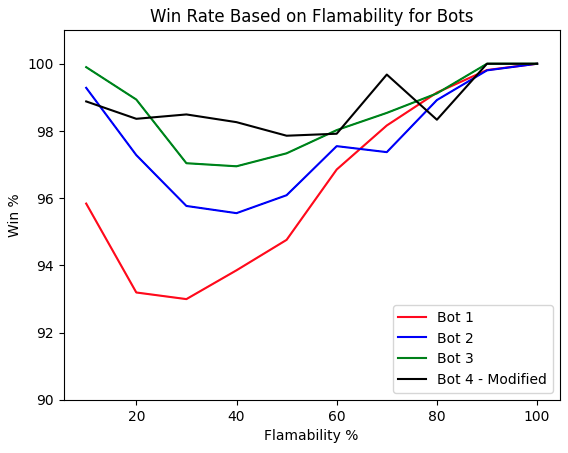

## Question 3: When bots fail or get trapped by the fire, why do they fail? Was there a better decision they could have made that would have saved them? Why or why not? Support your conclusions.


###Bot 1:

>This bot plans the shortest path to the button, avoiding the initial fire cell, and then executes that plan. The spread of the fire is ignored by the bot.
>
> Failure Cause: The bot plans the shortest path to the button without considering the fire. It fails when the fire consumes a cell in the initial shortest path that the bot has preplanned in its path to the button. In most cases when viewing how the bot progresses on the board, the bot often dives into the fire when the fire has consumed certain cells needed to reach the button on that shortest path. In the Bot 1 Moment of Failure, we can see that even instead of going down where the fire wasn't present, that the bot dives head first into the fire making this issue a simple one to adjust for in bots 2 and 3.
>
> Better decision that could have saved it: Succeeded by its predecessors, bot 2 and 3 account for the fire spreading, therefore, this bot could trace a new path whenever the initial shortest path is no longer viable. This way it would save itself from certain failure every time that the fire blocked its path. Although an elementary solution, it resolves the main issue regarding jumping into the fire.


#### Bot 1: Moment of Failure

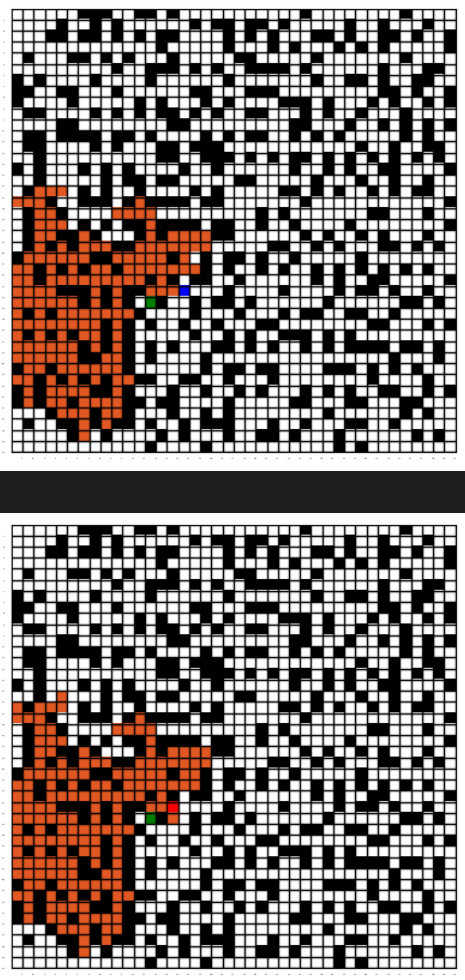

###Bot 2:


>At every time step, the bot re-plans the shortest path to the button, avoiding the current fire cells, and then executes the next step in the new path.
>
>Failure Cause: The bot plans a new path considering the new fire, so it won’t blindly walk into the fire. One of the main reasons for failure is that the bot walks into a cell adjacent to the fire and the fire spreads at the same time, consuming the bot. By only calculating a path clear of the fire, the bot fails to consider the possibility of the fires spreading onto its path when the bot is adjacent to the fire. As shown in the pictures below for Bot 2 failure, we can see that the bot is initially 2 squares away but moves a little closer to the fire, as determined by a clear path, but we can also see the node turn red, indicating that the bot was consumed by the fire in that same turn.
>
>Better decision that could have saved it: Succeeded by Bot 3, a better decision would be to have an algorithm that better plans and considers the probability of the fire spreading and avoiding cells adjacent to the fire at times. As an example with the picture of failure provided below, the bot could've move down which will maintained a possibility of 2 spaces away if the fire were to spread, but it can also move back and find an alternative path that would've been more safe than the step it took in the picture below.

#### Bot 2: Moment of Failure

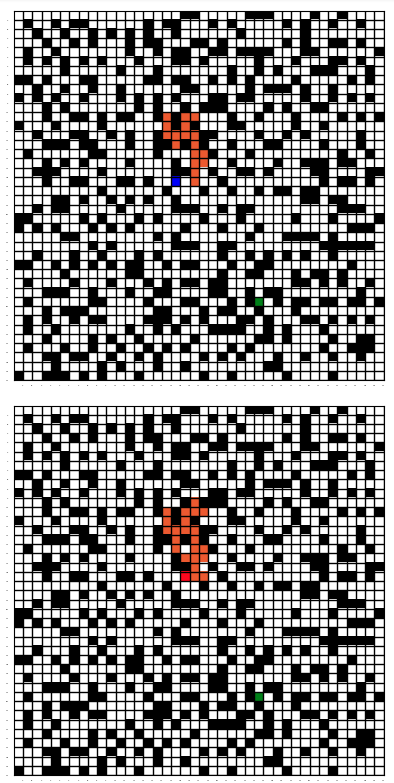

###Bot 3:

>At every time step, the bot re-plans the shortest path to the button, avoiding the current fire cells and any cells adjacent to current fire cells then executes the next step in that new path. If there is no such path, it plans the shortest path based only on current fire cells, then executes the next step in that new path.
>
>Failure Cause: Due to the bot avoiding all cells adjacent to the fire, it limits the bot's options when considering the available paths. Since there needs to be one block from the fire so that the bot can truly traverse a path, it may lead to backtracking when their initial shortest path to the button is closed off due to the fire. The pictures below show the action taken for Bot 3's failure. In the early game where the bot ends up, it has many options to reach the button, but it chooses to go down, as seen in the second photo. Between the second and third photos, we can see that by taking the lower path since the fire spread along the original path it needed to back up and reroute to find a “safer” path to the button. Still, in forgoing the chance to immediately head right to the button from the first image, it gave the fire ample time to spread, and when the bot is close to the button, we see in images 4 and 5 that it was already too late.
>
>Better decision that could have saved it: The bot could use risk assessment by seeing that the initial path that it planned didn’t account for enough variability in the fire spreading and caused it to lose the opportunity to reach the button on time. If it is able to balance the change of increasing the range, it should stay away from the fire while also not going to the furthest edge of the board to be “completely safe”. By balancing these two factors will the bot understand in the example that taking the route on the right would’ve been safer and though slightly more inefficient, a more probable way to teach the button on time.

#### Bot 3: Moment of Failure

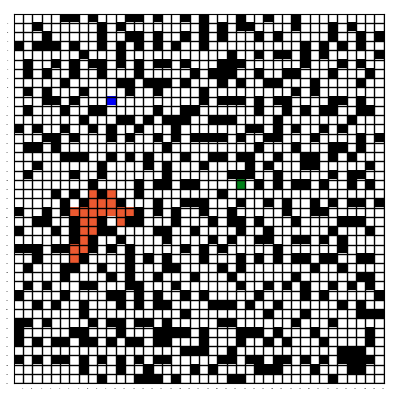

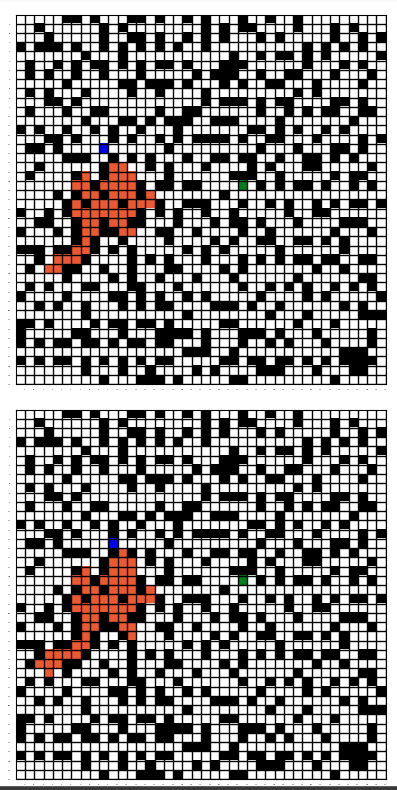

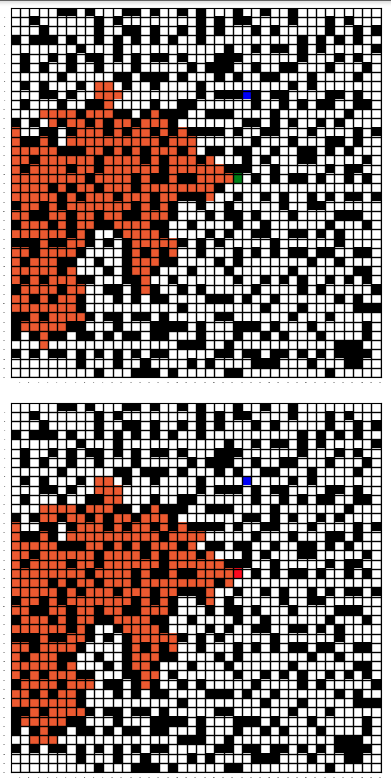

###Bot 4:

>Self-created algorithm as defined in Question 1
>
>Failure Cause: Bot 4 sometimes overestimates the ability of the fire spreading (q = 0.1) and the fire burns the button before the bot can reach it. As described by the algorithm for bot 4, the bot calculates the least dangerous path possible while reaching the button. in an instance where there are two paths present to reach the button, where one, if taken, would put the bot adjacent to the fire while the other is of larger length but takes much longer to traverse. In (q = 0.1) if such a path exists and the fire was 3 units away from the button while the bot's path safer path is 20 units to the button, then even though the bot can guarantee avoiding the fire by a considerable distance, by chance the fire could've spread the 3 units and reach the button before the bot can. Therefore, by taking this longer route, though safer, puts the button at risk of being consumed before the bot can reach it.
>
>Better decision that could have saved it: If bot could estimate the probability of the fire spreading more and count the time that has passed, like a proper offset for time taken since the fire last spread, then in the cases that it causes the bot to back track can be avoided as the fire inches closer to the button. This is also partially the reason why for q of 0.1 to 0.5 the path is only calculated once at board creation, to avoid backtracking and to increase the chances of going continuously towards the button, and at every step for q of 0.6 to 1, to be readily flexible when it comes to more active fires. Furthermore, even though it may be more difficult to calulate, in such a scenario it may be better to bolt it being near the fire to reach the button in fewers steps, but in a higher risk setting. In a larger example provided below, we can see in the first image that the bot prioritizes their own safety before getting closer to the button as the bot takes a lateral step away from the fire, but this will be the cause of its failure. In the second image, we can also see that near the end, the bot is still far away from the button, but also from the fire; therefore, the additional movements it takes to keep its distance away from the fire gave the fire a chance to spread and lead the bot to failure.

#### Bot 4: Moment of Failure

Early Game Board

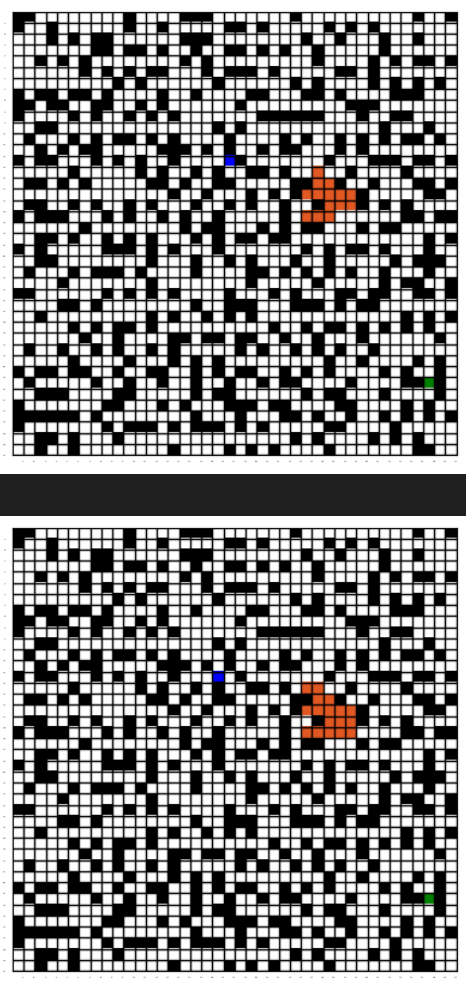

Late Game Board

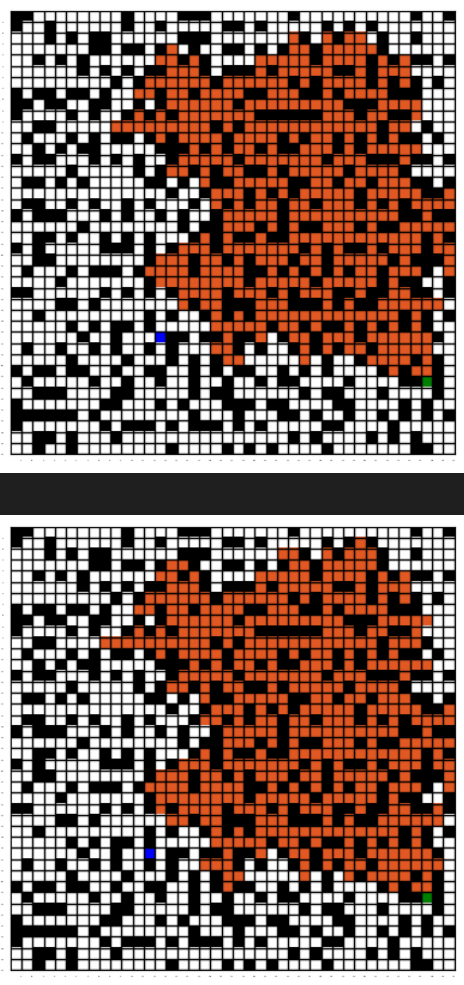

## Question 4: Speculate on how you might construct the ideal bot. What information would it use, what information would it compute, and how?


> **Information BOT would need to know for it to be ideal** - ship layout, current position of bot, button, fire location, and probability of the fire spreading. The bot would utilize the map we give it to plan a path considering whether neighboring cells are open or closed, dead ends, and the fire.
>
> **Computations that the bot would have to do** - The bot would have to recalculate the optimal path every time it takes a step based off of the current fire spread. The bot would take the formula for fire spread and simulate a couple boards with that fire probability and then pick a path that balances getting to the button on time and safety. It would use a logic that balances both speed and safety considering the fire spreads if it goes too slow.
>
>**Risk Assessment** - Ideally, the bot would construct possible paths and a couple scenarios with the fire spread the probability of success based on the compound calculation of the spreading of the fire for each step it takes.
>
> **IF WE COULD REALLY MAKE AN IDEAL BOT …** - It would integrate machine learning practices where the bot would learn from past trials. It would use neural networks that take as inputs boards of bots that succeed and the path they took. The output would be a board of 0s and 1s where 0s denote an area of the board to which the bot should not go and 1s an area to which the bot should go. The ideal output would be a board of 0s with a path of 1s from the initial bot position to the button.

## Bonus: Write an algorithm to find a ship layout that maximizes (as best you are able) the probability that some bot will be able to put out a random fire. Be clear as to your algorithm and results. Show me the actual ship layout you achieve, and data to support your conclusions.


In [ ]:
# Runs a spcific board on various fire, bot, and button locations, to evaluate the board's performance
def evaluate(game, num_simulations=500):
    successes = 0
    initial_board = clone_board(game)
    for i in range(num_simulations):
        if i % 100 == 0: print(i)
        game = clone_board(initial_board)
        x_fire = random.randint(1, game.width)
        y_fire = random.randint(1, game.height)
        while (not game.map[x_fire, y_fire].is_open):
            x_fire = random.randint(1, game.width)
            y_fire = random.randint(1, game.height)
        game.map[x_fire, y_fire].has_fire = True

        x_bot = random.randint(1, game.width)
        y_bot = random.randint(1, game.height)

        while (not game.map[x_bot, y_bot].is_open or game.map[x_bot, y_bot].has_fire):
            x_bot = random.randint(1, game.width)
            y_bot = random.randint(1, game.height)
        game.map[x_bot, y_bot].has_bot = True

        x_button = random.randint(1, game.width)
        y_button = random.randint(1, game.height)

        while (not game.map[x_button, y_button].is_open or game.map[x_button, y_button].has_fire or game.map[x_button, y_button].has_bot):
            x_button = random.randint(1, game.width)
            y_button = random.randint(1, game.height)
        game.map[x_button, y_button].has_button = True

        if simulate(game, x_button, y_button, x_bot, y_bot):
            successes += 1
    return successes / num_simulations

# Runs the board until the fire reaches the button and check if there exists a path from bot to button
def simulate(game, x_button, y_button, x_bot, y_bot):
    game_history = []
    game_history.append(game)
    while not game.map[x_button, y_button].has_fire:
        game = spreadFire_simple(game, 1)
        game_history.append(game)
    return check_winnable(game_history, x_bot, y_bot, x_button, y_button)

# After evaluating the bot, this function will modify the board based on mutations to open and close random non-disconnecting cells
def optimize_layout(size, iterations=100, mutations=10):
    best_layout = generate_board(size, size)
    best_score = evaluate(best_layout)

    for i in range(iterations):
        print("Cycle: ", i)
        current_layout = clone_board(best_layout)

        for j in range(mutations):
            # print("Mutations: ", j)
            x, y = random.randint(1, size), random.randint(1, size)
            while (current_layout.map[x, y].is_open or len(current_layout.map[x, y].open_neighbors) == 0):
                x, y = random.randint(1, size), random.randint(1, size)
            # print(f"Opening {x, y}")
            current_layout.creation_history.append((x, y))
            current_layout = clone_board(current_layout)

            disconnects = True
            while (not current_layout.map[x,y].is_open or disconnects):
                x, y = random.randint(1, size), random.randint(1, size)
                disconnects = False
                if len(current_layout.map[x,y].open_neighbors) > 1:
                    test_layout = clone_board(current_layout)
                    for i, element in enumerate(test_layout.creation_history):
                        if element == (x, y):
                            test_layout.creation_history.pop(i)
                            test_layout = clone_board(test_layout)
                    open_neighbors = list(test_layout.map[x,y].open_neighbors)
                    main_neighbor = open_neighbors[0]
                    for neighbor in open_neighbors[1:]:
                        path_exists = bfs_shortest_path(test_layout, main_neighbor.x, main_neighbor.y, neighbor.x, neighbor.y)
                        if path_exists == None: disconnects = True

            # print(f"Removeing{x, y}")
            for i, element in enumerate(current_layout.creation_history):
                if element == (x, y):
                    current_layout.creation_history.pop(i)
                    current_layout = clone_board(current_layout)

        current_layout = clone_board(current_layout)
        current_score = evaluate(current_layout)
        if current_score > best_score:
            best_layout = current_layout
            best_score = current_score

    return best_layout, best_score

# Execute the optimizations above
size = 40
best_layout, best_score = optimize_layout(size)
data = get_map_data(best_layout)
plot_grid(data, size, size)
print(f"Best layout score: {best_score}")

100% Flamability Testing

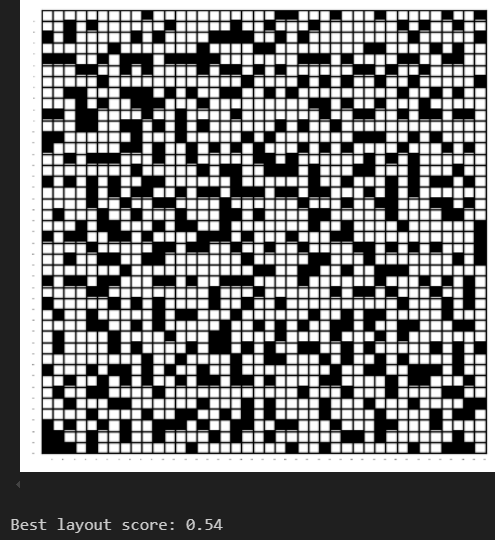

50% Flamability Testing

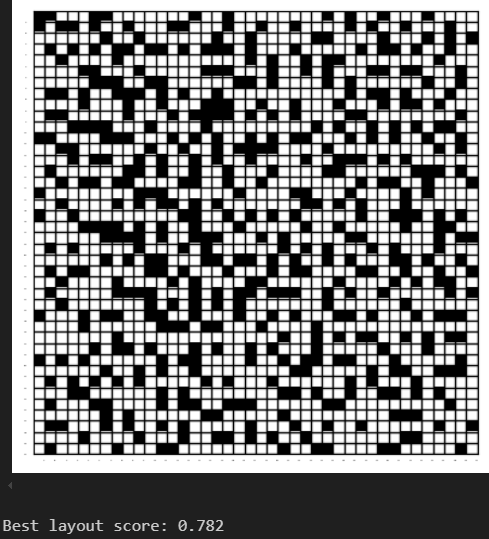

> I can't say that we're too proud with the resulting ship layout above, but this is the result of the algorithm and a given win percentage for approximately 500 games given a random fire, bot, and button with a 100%  and 50% flamability probability.
>
> The algorithm aboves uses the hill-climbing technique similar to the constraint satisfaction problems we have discussed in class. By taking an inital state of a board, any randomly generated board given the initial generation rules, then generated a bot, button, and fire that I run through time until the fire reaches the button. Afterwards an algorithm checks whether or not the bot had a direct path towards the button given the various epochs of the board. If there exists a path, then given the configuration of the bot, button, and fire, there exists a solution, otherwise there is no solution.
>
> I tested the board on q/flamability = 100% and 50% because for 100% flamability, every other instances of q or its flamability will be less and the bot will be more likely/more able to reach the button given the number of epochs it takes for the fire to reach the button, while the 50% board allows us to also explore how the possibility of the fire spreading more slowly and give us a more advantagous board. Therefore, by maximizing the fire spread, we check that given the extreme conditions the lowest bound of each board's proabability that given some bot and some fire that the bot will be able to reach the button before the fire, and by balancing the fire spread we can also see if allowing the fire to spread half as fast is a factor to board optimization.
>
> Although 500 games might not be enough to test the various cominations of the board to test for the best probability of its winnability, it was to decrease the overall runtime of this test. After the first iteration of 500 games, I get the win probability of the board and modify the board by removing around 10 cells and opening 10 others by random that doesn't disconnect the board. After doing so, another iteration of 500 games is executed to assess the winnability of the modified board. This board is then compared with the previous board's winnability and the algorithm will keep the best board based on whichever board has a higher winnability rate. This board will then be updated with the "mutations" by random and continuously tested. After 100 iterations of this process, the board shown above is considered the "best" or most probable for a bot to extinguish the fire. One adjustment though this process is, in order to aim closer to the "best" board, I decrease the number of cells opened and closed as the number of boards processed increased.
>
> I may have to run the test a few more times in order to get the "best" board between the various iterations of the algorithm and to avoid any local minima for number of losses. Regardless the board above shows the "best" board after one set of 500 iterations and with a >50% winnability rate for a 100% flamability and a >75% winnability rate for a 50% flamability. I would say that the 100% flamability board exceeds the winabiliity compared to a completely empty board as the win rate for that would be around 50%, therefore the cell placement on this board contribute a factor that allows the bot to win in slightly more cases than it loses.
>
> One thing that I can say about the board is the accessibility to various routes between patches of open cells. Although the more routes there are available, the more quickly the fire can spread, similarly there can be just as many routes that allow the bot to avoid the fire and reach the button. Because there is a factor of randomness when it comes to the fire spreading, the judgement of board with q < 1 isn't truly concrete unless the number of various iterations of the games is tested to infinity, but the difference between the 50% and 100% flamability board highlights a difference between a strict and more lenient fire spread. In the 50% flamability we can see more dead ends compared to the 100% flamability board. Though there are still deadends, likely due to the few number of iterations tested, if provided a longer iteration of a specific board, I believe that the boards will slowly converge to ones with few to no deadends. If given more time, I would like to test various iterations of the board on slowly increasing values of q from 0.1 to 0.9 while also testing on various boards sizes and number of iterations to grasps a more thorough details of a board and potential patterns that may maximize a bot to reach a button compared to the fire.

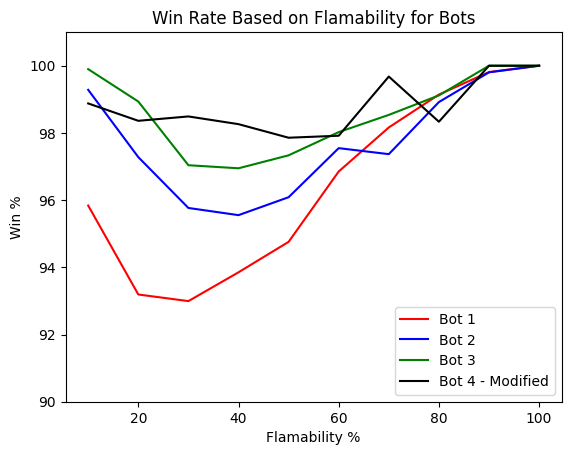

In [ ]:
win_percentage_1 = [95.83756345177665, 93.19148936170212, 92.99435028248587, 93.85194479297365, 94.75806451612904, 96.85157421289355, 98.16232771822358, 99.14089347079039, 99.812382739212, 100]
win_percentage_2 = [99.28205128205128, 97.27965179542981, 95.76659038901602, 95.55273189326556, 96.08636977058029, 97.54689754689755, 97.36842105263158, 98.91891891891892, 99.80276134122288, 100]
win_percentage_3 = [99.89806320081549, 98.93390191897655, 97.03872437357631, 96.94749694749694, 97.33333333333334, 98.0243161094225, 98.53658536585365, 99.1166077738516, 100, 100]
# win_percentage_4 = [95.53752535496957, 92.29122055674517, 93.86363636363636, 94.06175771971496, 97.3404255319149, 97.91666666666666, 99.67741935483872, 97.1731448763251, 100, 100]
win_percentage_4 = [98.87755102040816, 98.36065573770492, 98.49056603773585, 98.26086956521739, 97.85714285714285, 97.91666666666666, 99.67741935483872, 98.3333333333333, 100, 100]
# win_percentage_4_old = [98.9795918367347, 98.36065573770492, 98.49056603773585, 98.26086956521739, 97.85714285714285, 97.11340206185567, 97.43119266055047, 97.65886287625418, 97.86910197869102, 98.0309423347398]
#Maybe try 0.8 again
plt.plot(range(10, 101, 10), win_percentage_1, c="red", label="Bot 1")
plt.plot(range(10, 101, 10), win_percentage_2, c="blue", label="Bot 2")
plt.plot(range(10, 101, 10), win_percentage_3, c="green", label="Bot 3")
plt.plot(range(10, 101, 10), win_percentage_4, c="k", label="Bot 4 - Modified")
plt.legend(loc="lower right")
plt.xlabel("Flamability %")
plt.ylabel("Win %")
plt.title("Win Rate Based on Flamability for Bots")
plt.ylim(90, 101)
plt.show()